In [11]:
# # Save as GraphML
# ox.save_graphml(graph, "nantes.graphml")

# # Save as GeoPackage (for GIS tools like QGIS)
# ox.save_graph_geopackage(graph, filepath="nantes.gpkg")

# # Load the GraphML file
# graph = ox.load_graphml("nantes.graphml")

https://www.geonames.org/search.html?q=&country=FR

In [12]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

# Flags to control which networks to plot
plot_roads = True
plot_walk = True
plot_bike = True

# # Coordinates for Les Mottes, Vendée, France
# latitude = 46.52634
# longitude = -1.12103

# # Download the road network for the location
# road_graph = ox.graph_from_point((latitude, longitude), dist=500, network_type="drive")
# walk_graph = ox.graph_from_point((latitude, longitude), dist=500, network_type="walk")
# bike_graph = ox.graph_from_point((latitude, longitude), dist=500, network_type="bike")

# Download networks for different transportation types
road_graph = ox.graph_from_place("Sainte Gemme la Plaine, Vendée, France", network_type="drive")
walk_graph = ox.graph_from_place("Sainte Gemme la Plaine, Vendée, France", network_type="walk")
bike_graph = ox.graph_from_place("Sainte Gemme la Plaine, Vendée, France", network_type="bike")

# Extract positions of nodes (latitude and longitude) for each network
road_pos = {node: (data['x'], data['y']) for node, data in road_graph.nodes(data=True)}
walk_pos = {node: (data['x'], data['y']) for node, data in walk_graph.nodes(data=True)}
bike_pos = {node: (data['x'], data['y']) for node, data in bike_graph.nodes(data=True)}

In [13]:
# Extract positions (latitude, longitude) for each node
def get_node_positions(graph):
    return {node: (data['x'], data['y']) for node, data in graph.nodes(data=True)}

road_pos = get_node_positions(road_graph)
walk_pos = get_node_positions(walk_graph)
bike_pos = get_node_positions(bike_graph)

# Create a function to generate unique node names based on latitude and longitude
def rename_nodes_based_on_location(graph, positions):
    lat_lon_map = {}  # Map to store unique node names by (lat, lon)
    renamed_nodes = {}
    counter = 1
    
    for node, (lat, lon) in positions.items():
        location = (round(lat, 6), round(lon, 6))  # Round coordinates for precision
        if location not in lat_lon_map:
            lat_lon_map[location] = str(counter)
            counter += 1
        renamed_nodes[node] = lat_lon_map[location]
    
    # Rename nodes in the graph
    graph = nx.relabel_nodes(graph, renamed_nodes)

    # Update the positions dictionary to match the renamed nodes
    renamed_positions = {renamed_nodes[node]: pos for node, pos in positions.items()}

    return graph, renamed_positions

# Rename nodes for all networks based on geographical location
road_graph, road_pos = rename_nodes_based_on_location(road_graph, road_pos)
walk_graph, walk_pos = rename_nodes_based_on_location(walk_graph, walk_pos)
bike_graph, bike_pos = rename_nodes_based_on_location(bike_graph, bike_pos)

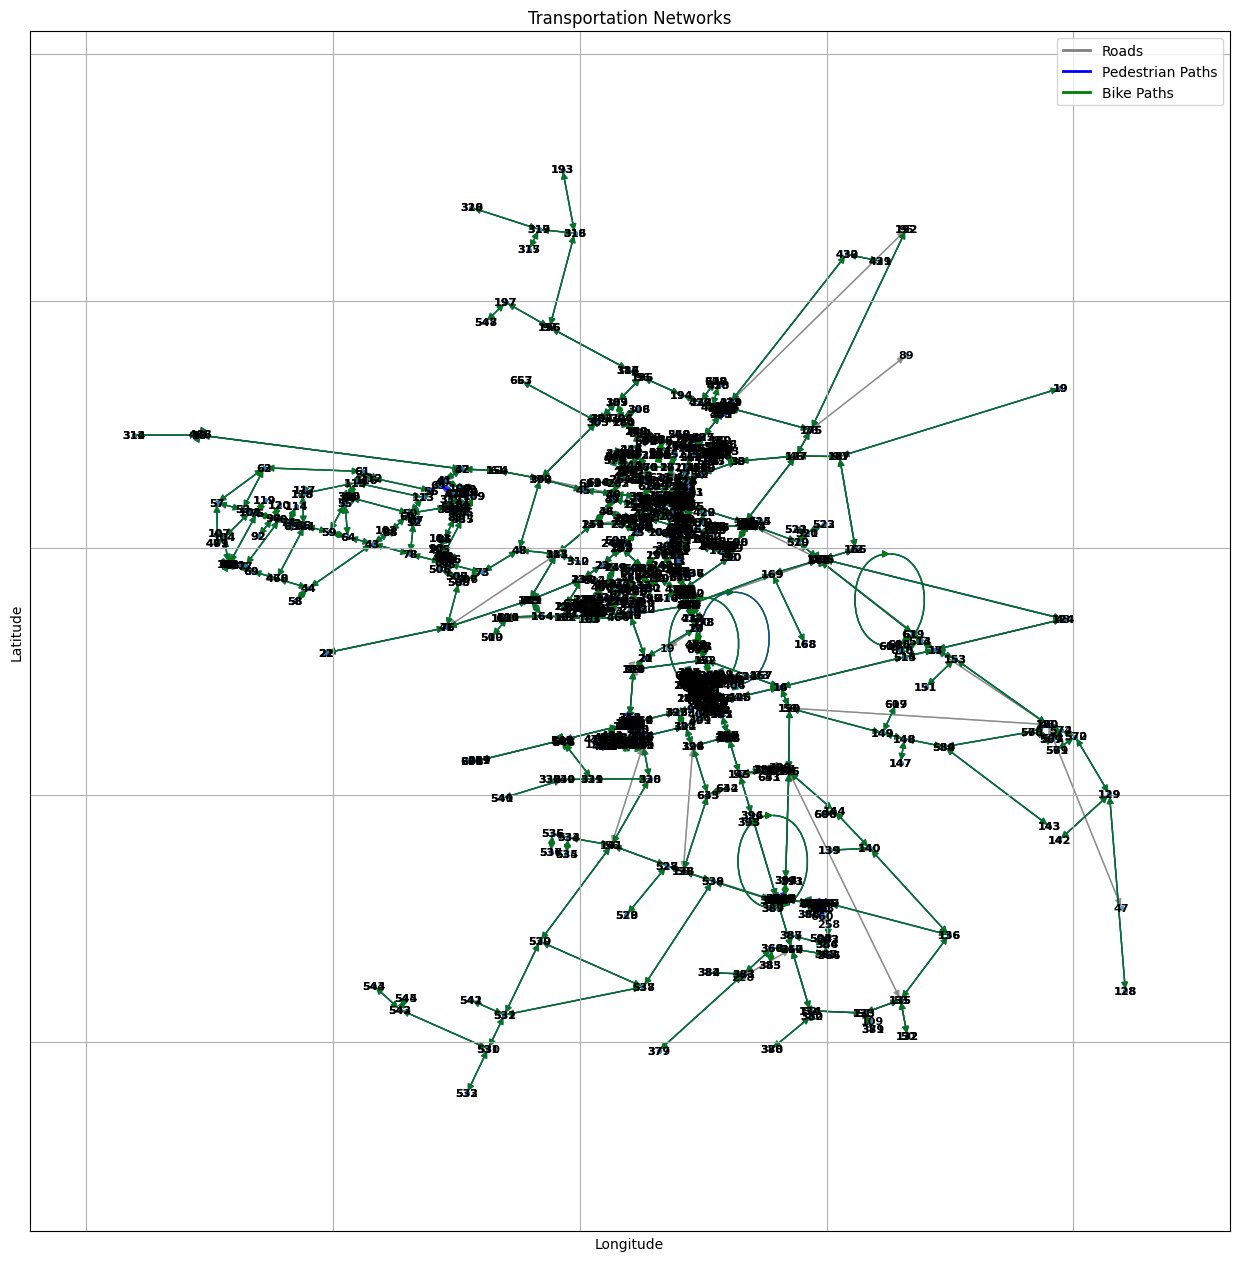

In [14]:
# Create the plot
plt.figure(figsize=(12, 12))

if plot_roads:
    nx.draw(road_graph, road_pos, node_size=10, edge_color="gray", linewidths=0.5, alpha=0.7, label="Roads")
    # Add node labels for the road network with sharp black font
    nx.draw_networkx_labels(road_graph, road_pos, font_size=8, font_color="black", font_weight='bold', font_family='sans-serif')

if plot_walk:
    nx.draw(walk_graph, walk_pos, node_size=10, edge_color="blue", linewidths=0.5, alpha=0.7, label="Pedestrian Paths")
    # Add node labels for the walk network with sharp black font
    nx.draw_networkx_labels(walk_graph, walk_pos, font_size=8, font_color="black", font_weight='bold', font_family='sans-serif')

if plot_bike:
    nx.draw(bike_graph, bike_pos, node_size=10, edge_color="green", linewidths=0.5, alpha=0.7, label="Bike Paths")
    # Add node labels for the bike network with sharp black font
    nx.draw_networkx_labels(bike_graph, bike_pos, font_size=8, font_color="black", font_weight='bold', font_family='sans-serif')

# Add a legend with colored labels
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color="gray", lw=2, label="Roads"),
    Line2D([0], [0], color="blue", lw=2, label="Pedestrian Paths"),
    Line2D([0], [0], color="green", lw=2, label="Bike Paths")
]
plt.legend(handles=legend_elements, loc="upper right")

# Add axes and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Transportation Networks")
plt.grid(visible=True)  # Add a grid for better orientation

# Add axes with scale
plt.gca().set_aspect('equal', adjustable='datalim')  # Set aspect ratio to equal
plt.axis('on')  # Enable axes

plt.show()

In [15]:
# for G in [road_graph,walk_graph,bike_graph]:
#     for node in G.nodes:
#         neighbors = list(G.neighbors(node))  # Get neighbors for each node
#         print(f"Node {node} has neighbors: {neighbors}")

In [16]:
def closest_node_pairs(graph, pos, n=5):
    def euclidean_distance(node1, node2, pos):
        x1, y1 = pos[node1]
        x2, y2 = pos[node2]
        return ((x2 - x1)**2 + (y2 - y1)**2)**0.5
    distances = []
    
    # Compare all pairs of nodes in the graph
    for node1 in graph.nodes():
        for node2 in graph.nodes():
            if node1 != node2:  # Skip comparing a node with itself
                distance = euclidean_distance(node1, node2, pos)
                distances.append((node1, node2, distance))
    
    # Sort by distance and return the n closest pairs
    distances.sort(key=lambda x: x[2])  # Sort by the third element (distance)
    
    return distances[:n]

# Example usage
closest_pairs = closest_node_pairs(road_graph, road_pos, n=5)

for node1, node2, distance in closest_pairs:
    print(f"Nodes {node1} and {node2} with distance {distance:.6f}")



Nodes 189 and 216 with distance 0.000038
Nodes 216 and 189 with distance 0.000038
Nodes 64 and 65 with distance 0.000051
Nodes 65 and 64 with distance 0.000051
Nodes 157 and 158 with distance 0.000052


In [20]:
def dijkstra_shortest_path(graph, source_label, target_label, weight='length'):
    try:
        # Compute the shortest path using Dijkstra
        path = nx.dijkstra_path(graph, source=source_label, target=target_label, weight=weight)
        return path
    except nx.NetworkXNoPath:
        return f"No path found between {source_label} and {target_label}"

# Example usage
source_node = '1'  # Example source node label
target_node = '15'  # Example target node label
shortest_path = dijkstra_shortest_path(road_graph, source_node, target_node)
print(f"Shortest path between {source_node} and {target_node}: {shortest_path}")

def euclidean_heuristic(node1, node2, pos):
    x1, y1 = pos[node1]
    x2, y2 = pos[node2]
    return ((x2 - x1)**2 + (y2 - y1)**2)**0.5

def a_star_shortest_path(graph, source_label, target_label, pos, weight='length'):
    try:
        # Compute the shortest path using A* with Euclidean distance heuristic
        path = nx.astar_path(graph, source=source_label, target=target_label, weight=weight, heuristic=lambda n1, n2: euclidean_heuristic(n1, n2, pos))
        return path
    except nx.NetworkXNoPath:
        return f"No path found between {source_label} and {target_label}"

# Example usage
source_node = '1'  # Example source node label
target_node = '15'  # Example target node label
shortest_path_a_star = a_star_shortest_path(road_graph, source_node, target_node, road_pos)
print(f"Shortest path between {source_node} and {target_node} using A*: {shortest_path_a_star}")

Shortest path between 1 and 15: ['1', '6', '5', '44', '14', '15']
Shortest path between 1 and 15 using A*: ['1', '6', '5', '44', '14', '15']


In [18]:
def simplify(graphS,lst):
    pass